**Thống kê máy tính và Ứng dụng**  
Học kì II, 2020 - 2021

<hr>

<br>
<center><b><font size="10">ĐỒ ÁN 1</font></b></center>
<br>

---

<center><b><font size="6"> Title </font></b></center>

<center>
    <b>Nhóm thực hiện:</b>
    <br>Trần Minh Trí - 1712834
    <br>Nguyễn Nhật Trường - 1712852
    <br> ...
    <br> ...
    <br> ...
</center>

* Desc 1.
* Desc 2.

<hr>

#### Các thư viện hỗ trợ

In [1]:
import datetime
from datetime import date
import pandas as pd

import time

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import statsmodels.api as sm
import os.path
import numpy as np
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import keras.backend as backend
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from keras import callbacks
import pickle

from sklearn import set_config
set_config(display='diagram')
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import gc

from IPython.display import display, HTML, clear_output

import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

from copy import copy
import os
import pickle

from sklearn.preprocessing import StandardScaler

from financial_features import *

from hmmlearn.hmm import GaussianHMM

from sklearn.model_selection import train_test_split

import itertools

from progressbar import Percentage, ProgressBar,Bar,ETA

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae

const_time_col = 'Date'
const_target_col = 'Close'
const_name_col = 'Name'

# 1. Thu thập dữ liệu

**Sử dụng Yahoo API**

In [2]:
def read_data(path, date_format='%Y-%m-%d'):
    all_stocks = pd.read_csv(path)
    all_stocks[const_time_col] = pd.to_datetime(all_stocks[const_time_col], format=date_format, errors='ignore')
    all_stocks = all_stocks.dropna(axis=0)
    all_stocks = all_stocks.set_index(const_time_col, drop=False)
    return all_stocks


def get_sp500_curr_stock_symbols():
    source = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    stock_df = source[0]
    return stock_df['Symbol'].to_list()


def save_stock_pulled(file_name, ticket_lists, start_date, end_date, interval='1d'):
    """
    The requested range [start_day, end_date] must be within:
        - the last 730 days for '1h' interval.
        - the last 60 days for '90m' interval
    """
    final_df = pd.DataFrame()
    attr_list = ['Open', 'High', 'Low', 'Close', 'Volume']

    for ticket in ticket_lists:
        df_ = pdr.get_data_yahoo(ticket, start=start_date, end=end_date, interval=interval)[attr_list]
        df_['Name'] = ticket
        final_df = pd.concat([final_df, df_])

    final_df.index = pd.to_datetime(final_df.index).strftime('%Y/%m/%dT%H:%M:%S')
    final_df.to_csv(file_name + '.csv', index_label='Date')
    return

In [3]:
#sp500 = get_sp500_curr_stock_symbols()
#save_stock_pulled('s&p500', sp500, '2005-01-01', '2021-05-30')

# 2. Tiền xử lí

In [4]:
def cal_features(data, norm_func=None, next_t=1, re_fit=True):
    feature_df = data[[const_target_col, 'Open']].copy()

    numeric_cols = data.select_dtypes(
        include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()

    feature_df['Close_proc'] = PROC(data['Close'], next_t) # Luôn giữ
    feature_df['frac_change'] = (data['Close'] - data['Open'])/data['Open']
    feature_df['frac_high'] = (data['High'] - data['Open'])/data['Open']
    feature_df['frac_low'] = (data['Open'] - data['Low'])/data['Open']
    
    return feature_df
    
    # Ko can norm

    if norm_func is not None:  # Normalize
        scaler = copy(norm_func)
        features = [] # Ft. to norm

        df = data.copy()
        df[features] = feature_df[features]
        if re_fit:
            scaler.fit(df[numeric_cols + features])
        data_norm = scaler.transform(df[numeric_cols + features])

        data_norm_df = pd.DataFrame(data_norm, columns=[s + '_norm' for s in numeric_cols + features])
        data_norm_df[const_time_col] = df.index
        data_norm_df = data_norm_df.set_index(const_time_col)

        feature_df = pd.concat([feature_df, data_norm_df], axis=1)

        return feature_df, scaler, [s + '_norm' for s in numeric_cols + features]

    return feature_df

# 3. Mô hình hóa

## 3.1. Đọc và xử lí dữ liệu

In [5]:
data = read_data('s&p500.csv', date_format='%Y-%m-%d')

stock = 'GOOGL'

stock_df = data[data[const_name_col] == stock]
stock_df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2004-12-31,2004-12-31,99.714714,100.040039,96.376373,96.491493,15321663.0,GOOGL
2005-01-03,2005-01-03,98.798798,101.921921,97.827827,101.456459,31656712.0,GOOGL
2005-01-04,2005-01-04,100.800804,101.566566,96.836838,97.347343,27484288.0,GOOGL
2005-01-05,2005-01-05,96.821823,98.548546,96.211212,96.851852,16456727.0,GOOGL
2005-01-06,2005-01-06,97.637634,98.048050,93.953957,94.369370,20753426.0,GOOGL


In [6]:
processed_df = cal_features(stock_df, norm_func=StandardScaler(), next_t=1, re_fit=True)
processed_df.head()

,Close,Open,Close_proc,frac_change,frac_high,frac_low
Date,,,,,,
2004-12-31,96.491493,99.714714,0.000000,-0.032324,0.003263,0.033479
2005-01-03,101.456459,98.798798,0.051455,0.026900,0.031611,0.009828
2005-01-04,97.347343,100.800804,-0.040501,-0.034260,0.007597,0.039325
2005-01-05,96.851852,96.821823,-0.005090,0.000310,0.017834,0.006307
2005-01-06,94.369370,97.637634,-0.025632,-0.033473,0.004203,0.037728


In [7]:
train_data, test_data = train_test_split(processed_df, test_size=0.15, shuffle=False)

In [8]:
train_data.head()

,Close,Open,Close_proc,frac_change,frac_high,frac_low
Date,,,,,,
2004-12-31,96.491493,99.714714,0.000000,-0.032324,0.003263,0.033479
2005-01-03,101.456459,98.798798,0.051455,0.026900,0.031611,0.009828
2005-01-04,97.347343,100.800804,-0.040501,-0.034260,0.007597,0.039325
2005-01-05,96.851852,96.821823,-0.005090,0.000310,0.017834,0.006307
2005-01-06,94.369370,97.637634,-0.025632,-0.033473,0.004203,0.037728


In [9]:
train_data.shape

(3511, 6)

In [10]:
test_data.head()

,Close,Open,Close_proc,frac_change,frac_high,frac_low
Date,,,,,,
2018-12-12,1073.729980,1077.079956,0.011378,-0.003110,0.013602,0.004744
2018-12-13,1073.540039,1075.670044,-0.000177,-0.001980,0.011853,0.009929
2018-12-14,1051.709961,1060.020020,-0.020335,-0.007840,0.011037,0.010047
2018-12-17,1025.650024,1047.010010,-0.024779,-0.020401,0.014680,0.029016
2018-12-18,1043.410034,1034.000000,0.017316,0.009101,0.024845,0.003404


In [11]:
test_data.shape

(620, 6)

## 3.2. Cài đặt mô hình HMM

In [12]:
n_hidden_states = 4
w_len = 10

In [13]:
def create_ft_vector(df, ft):
    col = [df[c] for c in ft]
    return np.column_stack(col)

In [14]:
class Open_HMM_Model:
    def __init__(self, n_components):
        self.frac_change_min, self.frac_change_max = None, None
        self.frac_high_min, self.frac_high_max = None, None
        self.frac_low_min, self.frac_low_max = None, None
        self.hmm = GaussianHMM(n_components=n_components)
        
    def fit(self, train_data=None):        
        ft_vector = create_ft_vector(train, ['frac_change', 'frac_high', 'frac_low'])
        self.hmm.fit(ft_vector)
        
        self.frac_change_min, self.frac_change_max = min(train['frac_change']), max(train['frac_change'])
        self.frac_high_min, self.frac_high_max = min(train['frac_high']), max(train['frac_high'])
        self.frac_low_min, self.frac_low_max = min(train['frac_low']), max(train['frac_low'])
        
    def compute_all_possible_outcomes(self, n_steps_frac_change, n_steps_frac_high, n_steps_frac_low):  
        frac_change_range = np.linspace(self.frac_change_min, self.frac_change_max, n_steps_frac_change)
        frac_high_range = np.linspace(self.frac_high_min, self.frac_high_max, n_steps_frac_high)
        frac_low_range = np.linspace(self.frac_low_min, self.frac_low_max, n_steps_frac_low)

        return np.array(list(itertools.product(frac_change_range, frac_high_range, frac_low_range)))
    
    def predict_day(self, dataset, day_index,  w_len):
        previous_data = dataset.iloc[max(0, day_index - w_len): max(0, day_index - 1)]
        previous_data_features = create_ft_vector(previous_data, ['frac_change', 'frac_high', 'frac_low'])

        outcome_score = []
        possible_outcomes = self.compute_all_possible_outcomes(50, 10, 10)

        for possible_outcome in possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))

        most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

        open_price = dataset.iloc[day_index]['Open']
        predicted_frac_change = most_probable_outcome[0]

        return open_price * (1 + predicted_frac_change)
    
    def predict(self, dataset, w_len):
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                       maxval=100).start()
        
        pred_close = []
        for i in pbar(range(w_len, dataset.shape[0])):
            pred_close.append(self.predict_day(dataset, i, w_len))
        return pred_close

In [15]:
class LastClose_HMM_Model:
    def __init__(self, n_components):
        self.proc_min, self.proc_max = None, None
        self.hmm = GaussianHMM(n_components=n_components)
        
        
    def fit(self, train_data=None):        
        ft_vector = create_ft_vector(train, ['Close_proc'])
        self.hmm.fit(ft_vector)
        
        self.proc_min, self.proc_max = min(train['Close_proc']), max(train['Close_proc'])
        
    def compute_all_possible_outcomes(self, n_steps):  
        return np.linspace(self.proc_min, self.proc_max, n_steps)
    
    def predict_day(self, dataset, day_index,  w_len):
        previous_data = dataset.iloc[max(0, day_index - w_len): max(0, day_index - 1)]
        previous_data_features = create_ft_vector(previous_data, ['Close_proc'])

        outcome_score = []
        possible_outcomes = self.compute_all_possible_outcomes(5000)

        for possible_outcome in possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))

        most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

        last_price = dataset.iloc[day_index-1]['Close']
        predicted_frac_change = most_probable_outcome

        return last_price * (1 + predicted_frac_change)
    
    def predict(self, dataset, w_len):
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                       maxval=100).start()
        
        pred_close = []
        for i in pbar(range(w_len, dataset.shape[0])):
            pred_close.append(self.predict_day(dataset, i, w_len))
        return pred_close

In [16]:
train, validation = train_test_split(train_data, test_size=0.2, shuffle=False)

In [17]:
model1 = Open_HMM_Model(n_components = n_hidden_states)

model1.fit(train)

In [18]:
pred1 = model1.predict(validation, w_len=10)

[==========================================================] 100% Time: 0:15:45


In [19]:
model2 = LastClose_HMM_Model(n_components = n_hidden_states)

model2.fit(train)

In [20]:
pred2 = model2.predict(validation, w_len=10)

[==========================================================] 100% Time: 0:15:23


In [27]:
df = pd.DataFrame(list(zip(validation['Close'][w_len:], pred1, pred2)), \
                  columns =['True val', 'Pred 1', 'Pred 2'], index=validation[w_len:].index)

In [28]:
mape(df['True val'], df['Pred 1'])*100, mae(df['True val'], df['Pred 1'])

(1.0887065634316335, 10.57280499909489)

In [29]:
mape(df['True val'], df['Pred 2'])*100, mae(df['True val'], df['Pred 2'])

(0.9275279301053633, 9.079501614414564)

## 3.3 Đánh giá mô hình

In [30]:
def plot_model_prediction(Y, predicted_Y, idx, title='', eval_error=False, zoom_in=[], zoom_title=''):
    valid_vs_prediction = pd.DataFrame({'Actual': Y}, index=idx)
    valid_vs_prediction['Predicted'] = predicted_Y
    valid_vs_prediction['Error'] = valid_vs_prediction['Actual'] - valid_vs_prediction['Predicted']
    
    
    std_part = 1.96 # Độ tin cậy 95%, [11]
    err_std = valid_vs_prediction['Error'].std(axis=0)
    err_mean = np.absolute(valid_vs_prediction['Error'].mean(axis=0))

    pred_upper = valid_vs_prediction['Predicted'] + err_mean + err_std * std_part
    pred_lower = valid_vs_prediction['Predicted'] - err_mean - err_std * std_part
    
    if eval_error: 
        print('Comparing metric:')
        print(' - MAPE:', mape(valid_vs_prediction['Actual'], valid_vs_prediction['Predicted'])*100, '%')
        print(' - MAE:', mae(valid_vs_prediction['Actual'], valid_vs_prediction['Predicted']))
        print('Error.describe:')
        print(valid_vs_prediction['Error'].describe())
        plt.figure(figsize=(8,4))
        valid_vs_prediction['Error'].hist(bins=50).set_title('Error distribution')
        plt.show()
        plt.figure(figsize=(8,4))
        valid_vs_prediction['Error'].plot(kind='box', grid=True).set_title("Error")
        plt.show()
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Closing Price', fontsize=18)
    plt.plot(valid_vs_prediction['Actual'], color='b')
    plt.plot(valid_vs_prediction['Predicted'], color='r')
    plt.fill_between(x=valid_vs_prediction.index, y1=pred_upper, y2=pred_lower, 
                     color='green', lw=2, alpha=0.2)
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()
    
    if len(zoom_in) > 0:
        plt.figure(figsize=(16,10))
        plt.title(zoom_title)
        plt.plot(valid_vs_prediction['Actual'][zoom_in[0]:zoom_in[1]], 
                 label='Actual', marker='o', color='b')
        plt.plot(valid_vs_prediction['Predicted'][zoom_in[0]:zoom_in[1]], 
                 label='Predicted', marker='o', color='r')
        plt.fill_between(x=valid_vs_prediction.index[zoom_in[0]:zoom_in[1]], 
                         y1=pred_upper[zoom_in[0]:zoom_in[1]], 
                         y2=pred_lower[zoom_in[0]:zoom_in[1]], color='green', lw=2, alpha=0.2)
        plt.legend(loc='lower right')
        plt.show()

Comparing metric:
 - MAPE: 1.0887065634316335 %
 - MAE: 10.57280499909489
Error.describe:
count    693.000000
mean       7.176600
std       11.768665
min      -53.485489
25%        1.962011
50%        7.166828
75%       12.442581
max       58.299708
Name: Error, dtype: float64


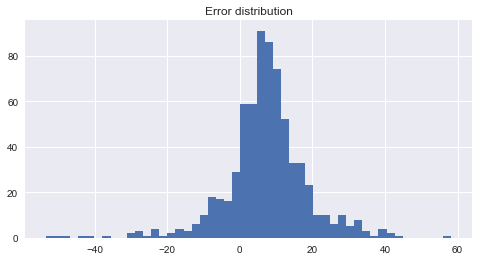

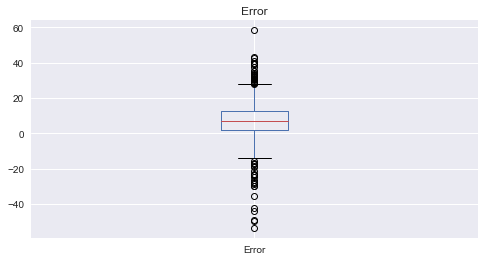

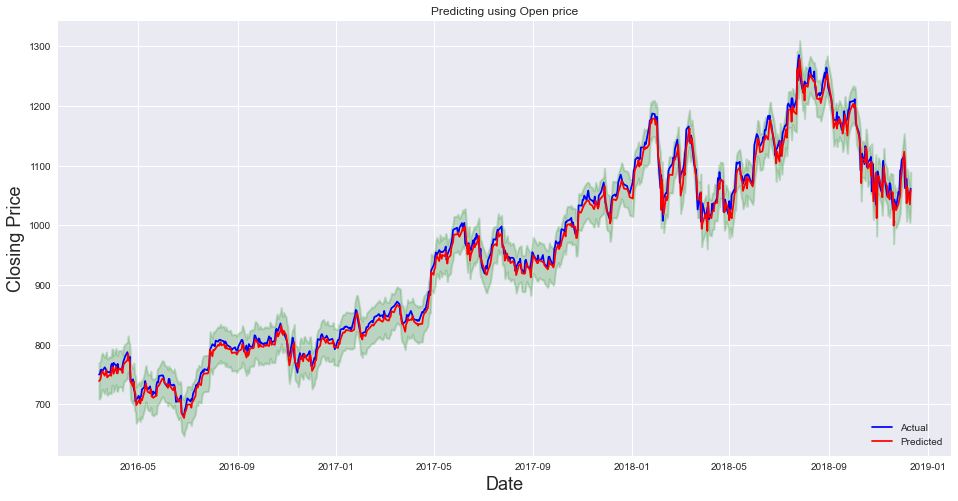

In [31]:
plot_model_prediction(df['True val'], df['Pred 1'], idx=df.index, title = 'Predicting using Open price', eval_error=True)

Comparing metric:
 - MAPE: 0.9275279301053633 %
 - MAE: 9.079501614414564
Error.describe:
count    693.000000
mean      -0.656534
std       13.372451
min      -63.773252
25%       -5.492953
50%        0.036995
75%        5.984742
max       45.732358
Name: Error, dtype: float64


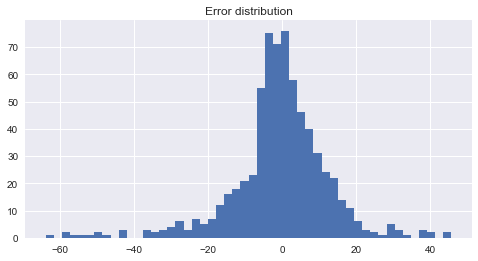

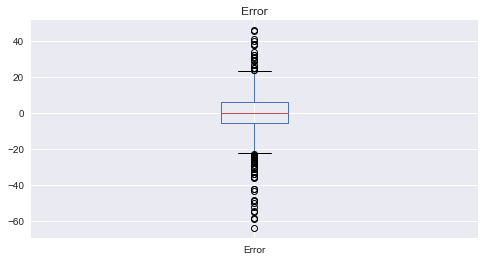

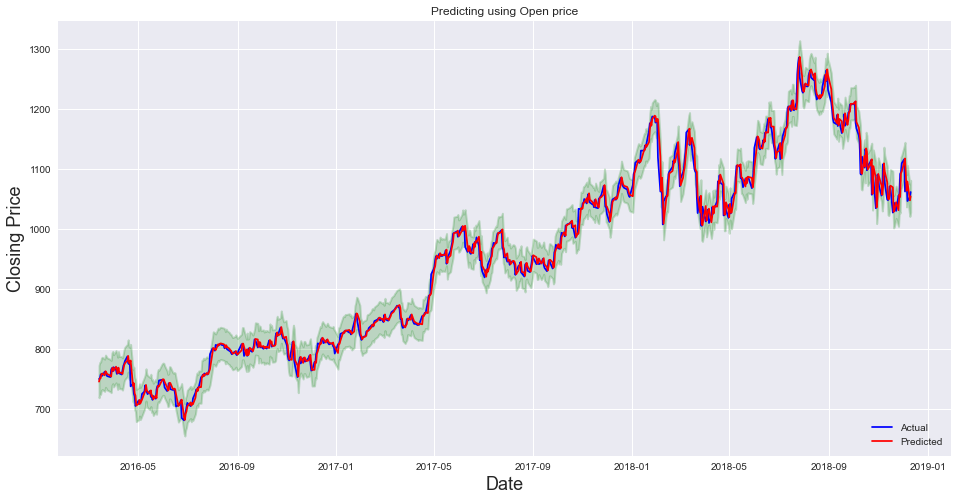

In [32]:
plot_model_prediction(df['True val'], df['Pred 2'], idx=df.index, title = 'Predicting using Open price', eval_error=True)